In [ ]:
import pandas as pd
from pathlib import Path

DATA_PATH = Path("..") / "data" / "baseline_inputs.csv"

baseline = pd.read_csv(DATA_PATH)

required_cols = {"Metric", "Value", "Units", "Year"}
missing = required_cols - set(baseline.columns)
if missing:
    raise ValueError(f"baseline_inputs.csv is missing columns: {missing}")

def to_key(s: str) -> str:
    return (
        str(s).strip().lower()
        .replace("&", "and")
        .replace("/", "_")
        .replace("-", "_")
        .replace(" ", "_")
    )

baseline["metric_key"] = baseline["Metric"].apply(to_key)

baseline["Value"] = (
    baseline["Value"]
    .astype(str)
    .str.replace(",", "", regex=False)
)

baseline["Value"] = pd.to_numeric(baseline["Value"], errors="raise")

vals = dict(zip(baseline["metric_key"], baseline["Value"]))

# Helper
def get_value(possible_keys):
    for k in possible_keys:
        if k in vals:
            return vals[k]
    raise KeyError(f"None of these metric keys were found: {possible_keys}\nFound keys: {sorted(vals.keys())}")


fare_revenue = get_value(["bus_fare_revenue", "fare_revenue", "bus_fare_rev"])
operating_cost = get_value(["bus_operating_cost", "operating_cost", "bus_ops_cost"])
annual_ridership = get_value(["annual_bus_ridership", "bus_ridership", "annual_ridership"])
time_horizon = get_value(["time_horizon", "horizon", "years"])

print("Loaded baseline inputs:")
print(f"  fare_revenue     = {fare_revenue:,.0f}")
print(f"  operating_cost   = {operating_cost:,.0f}")
print(f"  annual_ridership = {annual_ridership:,.0f}")
print(f"  time_horizon     = {time_horizon:.0f} year(s)")

if fare_revenue <= 0 or operating_cost <= 0:
    raise ValueError("Fare revenue and operating cost should be positive numbers.")

if time_horizon <= 0:
    raise ValueError("Time horizon must be >= 1.")

# Ridership
if annual_ridership < 10_000_000:
    print("\n⚠️  Warning: annual_ridership is under 10,000,000.")
    print("   That may be DAILY ridership, not ANNUAL. If it's daily, annualize it (daily * 365).")

# Ratio check: fare revenue vs operating cost
fare_share = fare_revenue / operating_cost
print(f"\nFare revenue as a share of operating cost: {fare_share:.2%}")


Loaded baseline inputs:
  fare_revenue     = 850,000,000
  operating_cost   = 6,200,000,000
  annual_ridership = 1,900,000,000
  time_horizon     = 1 year(s)

Fare revenue as a share of operating cost: 13.71%


In [ ]:
# Assumptions

ASSUMPTIONS_PATH = Path("..") / "data" / "assumptions.csv"

assumptions_df = pd.read_csv(ASSUMPTIONS_PATH)

print("Loaded assumptions:")
display(assumptions_df)


Loaded assumptions:


,Parameter,Distribution,Low,Mean,High,Units,Unnamed: 6
0,Ridership Increase,Triangular,0.050,0.15,0.350,Percent,Observed in fare-free pilots
1,Cost Inflation,Normal,0.015,0.03,0.045,Percent,Recent CPI Range
2,Service Scaling Factor,Normal,0.200,0.40,0.600,Ratio,Partial Capacity Response
3,Revenue Uncertainty,Normal,-0.050,0.00,0.050,Percent,Budget Forecasting Noise


In [ ]:
# Scenarios ---

from pathlib import Path
import pandas as pd

SCENARIOS_PATH = Path("..") / "data" / "scenarios.csv"

scenarios_df = pd.read_csv(SCENARIOS_PATH)

scenarios_df["Scenario"] = scenarios_df["Scenario"].fillna("None").astype(str).str.strip()
display(scenarios_df)


Loaded scenarios:


,Scenario,Replacement rate,Description
0,None,0.0,No replacement funding
1,Partial,0.5,50 % subsidy
2,Full,1.0,Full fare replacement


In [ ]:
import numpy as np

# Helper
def get_param(name):
    row = assumptions_df[assumptions_df["Parameter"] == name]
    if row.empty:
        raise ValueError(f"Parameter not found: {name}")
    return row.iloc[0]

def sample_ridership_increase():
    p = get_param("Ridership Increase")
    return np.random.triangular(p["Low"], p["Mean"], p["High"])

def sample_cost_inflation():
    p = get_param("Cost Inflation")
    return np.random.normal(p["Mean"], (p["High"] - p["Low"]) / 4)

def sample_service_scaling():
    p = get_param("Service Scaling Factor")
    return np.random.normal(p["Mean"], (p["High"] - p["Low"]) / 4)

def sample_revenue_uncertainty():
    p = get_param("Revenue Uncertainty")
    return np.random.normal(p["Mean"], (p["High"] - p["Low"]) / 4)


In [ ]:
# Check

for _ in range(5):
    print(
        f"Ridership ↑: {sample_ridership_increase():.2%}, "
        f"Inflation: {sample_cost_inflation():.2%}, "
        f"Service scale: {sample_service_scaling():.2f}"
    )


Ridership ↑: 15.09%, Inflation: 2.43%, Service scale: 0.18
Ridership ↑: 9.49%, Inflation: 2.71%, Service scale: 0.36
Ridership ↑: 20.34%, Inflation: 4.45%, Service scale: 0.40
Ridership ↑: 8.80%, Inflation: 2.13%, Service scale: 0.46
Ridership ↑: 7.65%, Inflation: 2.83%, Service scale: 0.27


In [ ]:
# One-year simulation function

def simulate_one_year(scenario_row):
    """
    Simulate one year of budget impact for a fare-free bus policy under uncertainty.

    Inputs:
      scenario_row: a row from scenarios_df (e.g., replacement_rate = 0, 0.5, 1)

    Returns:
      dict with net_balance and intermediate components (useful for debugging)
    """
    
    ridership_increase = sample_ridership_increase()          # e.g., 0.15 = +15%
    cost_inflation = sample_cost_inflation()                 # e.g., 0.03 = +3%
    service_scaling = sample_service_scaling()               # e.g., 0.40
    revenue_noise = sample_revenue_uncertainty()             # e.g., 0.02 = +2%

    
    base_fare_rev = fare_revenue * (1 + revenue_noise)
    base_op_cost = operating_cost * (1 + cost_inflation)

    
    lost_fare_revenue = base_fare_rev                         # fare-free => lose all fare rev
    extra_service_cost = base_op_cost * (ridership_increase * service_scaling)

    
    replacement_rate = float(scenario_row["Replacement rate"])
    replacement_funding = lost_fare_revenue * replacement_rate

    
    net_balance = replacement_funding - lost_fare_revenue - extra_service_cost

    return {
        "net_balance": net_balance,
        "lost_fare_revenue": lost_fare_revenue,
        "extra_service_cost": extra_service_cost,
        "replacement_funding": replacement_funding,
        "ridership_increase": ridership_increase,
        "cost_inflation": cost_inflation,
        "service_scaling": service_scaling,
        "revenue_noise": revenue_noise,
        "scenario": scenario_row["Scenario"],
        "replacement_rate": replacement_rate,
    }


In [ ]:
# Test the function once per scenario

for _, row in scenarios_df.iterrows():
    result = simulate_one_year(row)
    print(row["Scenario"], "=> net_balance:", f'{result["net_balance"]:,.0f}')


nan => net_balance: -1,281,371,960
Partial => net_balance: -634,857,198
Full => net_balance: -723,165,595


In [ ]:
import numpy as np
import pandas as pd

N_SIMS = 10_000
all_results = []

for _, row in scenarios_df.iterrows():
    for _ in range(N_SIMS):
        r = simulate_one_year(row)
        all_results.append({
            "scenario": r["scenario"],
            "replacement_rate": r["replacement_rate"],
            "net_balance": r["net_balance"],
            "lost_fare_revenue": r["lost_fare_revenue"],
            "extra_service_cost": r["extra_service_cost"],
            "replacement_funding": r["replacement_funding"],
            "ridership_increase": r["ridership_increase"],
            "cost_inflation": r["cost_inflation"],
            "service_scaling": r["service_scaling"],
            "revenue_noise": r["revenue_noise"],
        })

results_df = pd.DataFrame(all_results)

print("Results shape:", results_df.shape)
display(results_df.head())


Results shape: (30000, 10)


,scenario,replacement_rate,net_balance,lost_fare_revenue,extra_service_cost,replacement_funding,ridership_increase,cost_inflation,service_scaling,revenue_noise
0,None,0.0,-1.269237e+09,8.279309e+08,4.413062e+08,0.0,0.146810,0.039770,0.466289,-0.025964
1,None,0.0,-1.249898e+09,8.497816e+08,4.001162e+08,0.0,0.131723,0.032416,0.474546,-0.000257
2,None,0.0,-1.511152e+09,8.308859e+08,6.802657e+08,0.0,0.188079,0.021289,0.571213,-0.022487
3,None,0.0,-1.278084e+09,9.148461e+08,3.632375e+08,0.0,0.101088,0.040039,0.557252,0.076290
4,None,0.0,-1.346038e+09,8.339186e+08,5.121194e+08,0.0,0.190576,0.027569,0.421794,-0.018919


In [ ]:
summary = (
    results_df
    .assign(deficit=lambda d: d["net_balance"] < 0,
            deficit_amount=lambda d: np.where(d["net_balance"] < 0, -d["net_balance"], 0))
    .groupby("scenario")
    .agg(
        sims=("net_balance", "size"),
        deficit_prob=("deficit", "mean"),
        mean_net_balance=("net_balance", "mean"),
        median_net_balance=("net_balance", "median"),
        p05_net_balance=("net_balance", lambda x: np.percentile(x, 5)),   # bad tail
        p95_net_balance=("net_balance", lambda x: np.percentile(x, 95)), # good tail
        median_deficit=("deficit_amount", "median"),
        p95_deficit=("deficit_amount", lambda x: np.percentile(x, 95)),
    )
    .reset_index()
    .sort_values("deficit_prob", ascending=False)
)


money_cols = ["mean_net_balance","median_net_balance","p05_net_balance","p95_net_balance","median_deficit","p95_deficit"]
summary[money_cols] = summary[money_cols].round(0)

display(summary)


,scenario,sims,deficit_prob,mean_net_balance,median_net_balance,p05_net_balance,p95_net_balance,median_deficit,p95_deficit
0,Full,10000,1.0,-4.686046e+08,-4.390808e+08,-8.451307e+08,-1.920370e+08,4.390808e+08,8.451307e+08
1,None,10000,1.0,-1.315744e+09,-1.289520e+09,-1.684419e+09,-1.040428e+09,1.289520e+09,1.684419e+09
2,Partial,10000,1.0,-8.951566e+08,-8.663563e+08,-1.277509e+09,-6.135871e+08,8.663563e+08,1.277509e+09


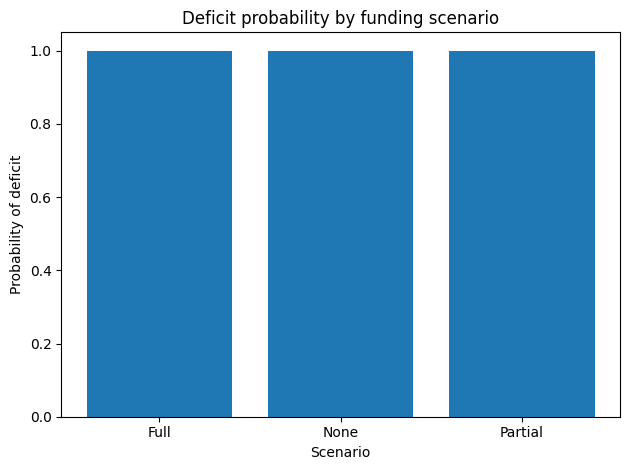

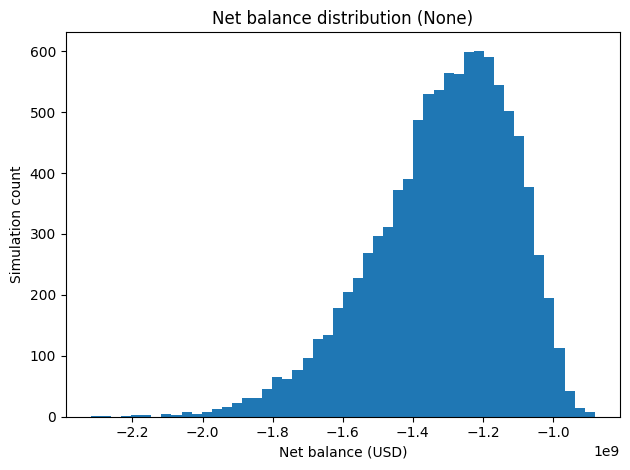

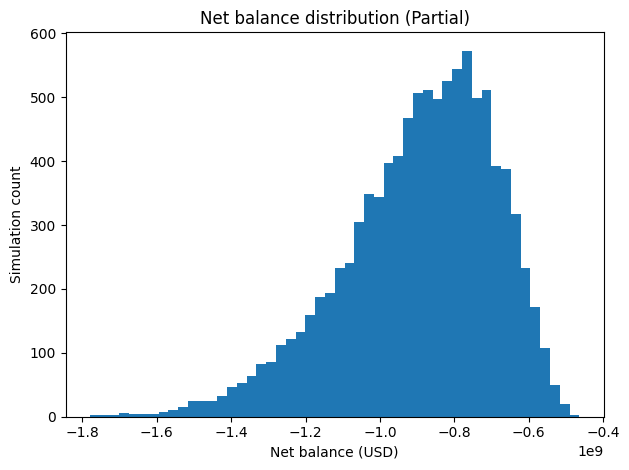

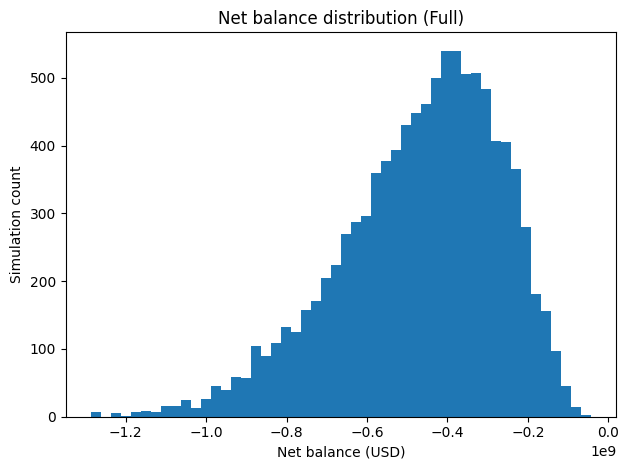

In [ ]:
import matplotlib.pyplot as plt

# 1) Deficit probability bar chart
plt.figure()
plt.bar(summary["scenario"], summary["deficit_prob"])
plt.title("Deficit probability by funding scenario")
plt.xlabel("Scenario")
plt.ylabel("Probability of deficit")
plt.tight_layout()
plt.savefig("../figures/deficit_probability_by_scenario.png", dpi=200)
plt.show()

# 2) Histogram of net balance for each scenario
for scen in results_df["scenario"].unique():
    plt.figure()
    x = results_df.loc[results_df["scenario"] == scen, "net_balance"]
    plt.hist(x, bins=50)
    plt.title(f"Net balance distribution ({scen})")
    plt.xlabel("Net balance (USD)")
    plt.ylabel("Simulation count")
    plt.tight_layout()
    
    # Different filename for each scenario
    plt.savefig(f"../figures/net_balance_{scen.lower()}.png", dpi=200)
    plt.show()



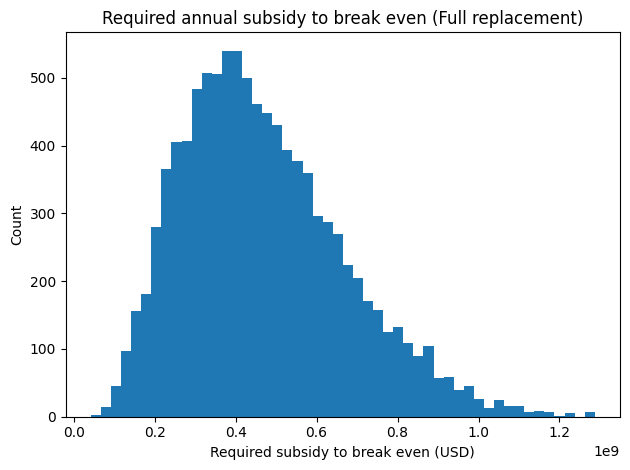

In [ ]:
# Required subsidy distribution

full_df = results_df[results_df["scenario"] == "Full"].copy()

required_subsidy = (
    -full_df["net_balance"]
).clip(lower=0)

plt.figure()
plt.hist(required_subsidy, bins=50)
plt.title("Required annual subsidy to break even (Full replacement)")
plt.xlabel("Required subsidy to break even (USD)")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("../figures/required_subsidy_full.png", dpi=200)
plt.show()

